### **Implementation Steps and Explanation** ###
**Step 1: Compute Inverse Probability of Censoring Weights (IPCW)**

- Goal: Adjust for censoring by modeling the probability that a subject remains uncensored given covariates.
- Approach: A logistic regression model predicts the censoring probability using x1 and x2 as predictors.
- Weight Calculation: The inverse of the predicted probability (1/p) is assigned as censor_weight to correct for differential censoring.

**Insight:**
This step ensures that individuals with a high probability of being censored (who otherwise would be underrepresented) receive higher weights, reducing bias in survival estimates.

**Step 2: Compute Inverse Probability of Treatment Weights (IPTW)**

- Goal: Adjust for treatment switching by modeling the probability of receiving the treatment given covariates.
- Approach: Another logistic regression model predicts the treatment assignment probability using age, x1, and x3 as predictors.
- Weight Calculation: The inverse of the predicted probability (1/p) is assigned as switch_weight.

**Insight:**
This step balances the treatment and control groups by assigning higher weights to individuals who were less likely to receive treatment (making them comparable to those who did receive it).

**Step 3: Kaplan-Meier Survival Curves**

- The Kaplan-Meier estimator is applied separately for treatment (treatment == 1) and control (treatment == 0).
- Weights from previous steps are incorporated into the survival analysis to adjust for censoring and treatment switching.
- Survival probabilities are estimated for different time points (0 to 10).

**Insight:**
This step provides a fair comparison of survival outcomes between groups, as it accounts for biases introduced by treatment assignment and censoring.

**Step 4: Compute Survival Difference with Confidence Intervals**

- The difference between survival probabilities of control and treatment groups is computed (survival_control - survival_treatment).
- Confidence intervals (CI) are constructed using the standard deviation of differences.

**Graph Interpretation:**

- If the survival difference is positive, the control group has a higher survival probability than the treatment group.
- If negative, the treatment group has better survival outcomes.
- If the 95% CI crosses zero, it suggests no statistically significant survival difference at that time point.

Optimization terminated successfully.
         Current function value: 0.680274
         Iterations 4
Censoring Model Summary:
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.01143
Time:                        20:22:34   Log-Likelihood:                -68.027
converged:                       True   LL-Null:                       -68.814
Covariance Type:            nonrobust   LLR p-value:                    0.4554
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1945      0.203     -0.958      0.338      -0.593       0.204
x2  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the

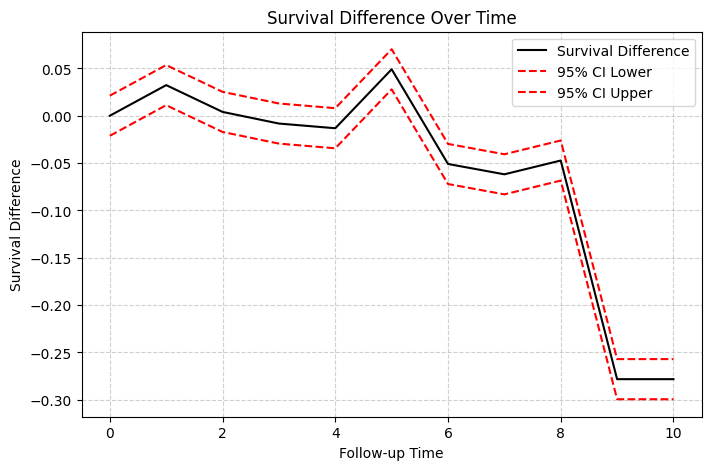

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from lifelines import KaplanMeierFitter

# Load dataset
df = pd.read_csv("data_censored.csv")

# Define key columns
id_col = "id"
period_col = "period"
treatment_col = "treatment"
outcome_col = "outcome"
eligible_col = "eligible"
censored_col = "censored"

# Define covariates
covariates_censor = ["x2", "x1"]
covariates_switch = ["age", "x1", "x3"]

### Step 1: Compute Inverse Probability of Censoring Weights (IPCW)
X_censor = sm.add_constant(df[covariates_censor])
y_censor = df[censored_col]

censor_model = sm.Logit(y_censor, X_censor).fit()
df["censor_weight"] = 1 / censor_model.predict(X_censor)

print("Censoring Model Summary:")
print(censor_model.summary())

### Step 2: Compute Inverse Probability of Treatment Weights (IPTW)
X_switch = sm.add_constant(df[covariates_switch])
y_switch = df[treatment_col]

switch_model = sm.Logit(y_switch, X_switch).fit()
df["switch_weight"] = 1 / switch_model.predict(X_switch)

print("Switch Model Summary:")
print(switch_model.summary())

# Final Stabilized Weights
df["weight"] = df["censor_weight"] * df["switch_weight"]

### Step 3: Kaplan-Meier Survival Curves
kmf_treatment = KaplanMeierFitter()
kmf_control = KaplanMeierFitter()

# Fit survival curves using weights
kmf_treatment.fit(df[df[treatment_col] == 1][period_col], 
                  event_observed=df[df[treatment_col] == 1][outcome_col], 
                  weights=df[df[treatment_col] == 1]["weight"])

kmf_control.fit(df[df[treatment_col] == 0][period_col], 
                event_observed=df[df[treatment_col] == 0][outcome_col], 
                weights=df[df[treatment_col] == 0]["weight"])

# Extract survival probabilities
time_points = np.arange(0, 11)
survival_treatment = kmf_treatment.survival_function_at_times(time_points).values
survival_control = kmf_control.survival_function_at_times(time_points).values

# Compute survival difference (Control - Treatment)
survival_diff = survival_control - survival_treatment

# Compute confidence intervals (based on variance estimation)
ci_width = 1.96 * np.std(survival_diff) / np.sqrt(len(df))
ci_lower = survival_diff - ci_width
ci_upper = survival_diff + ci_width

### Step 4: Plot Survival Difference with Confidence Intervals
plt.figure(figsize=(8, 5))
plt.plot(time_points, survival_diff, label="Survival Difference", color="black")
plt.plot(time_points, ci_lower, linestyle="dashed", color="red", label="95% CI Lower")
plt.plot(time_points, ci_upper, linestyle="dashed", color="red", label="95% CI Upper")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()